# **ESPIDAM: The Impact of Random Seeds on Training**
***Authors: Bram Silue, Prof. dr. Pieter Libin, Prof. dr. Niel Hens.***

### **How to Run**
If you're having trouble running this code on your local machine, please open and run this notebook in Colab:

[![colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/plibin/espidam-25/blob/main/deep-rl/2_seed_impact.ipynb)

We define some helper code that allows this notebook to run in both local environments and Google Colab:

In [1]:
def is_running_in_colab() -> bool:
    """
    Returns if the code is running inside Google Colab.

    """
    try:
        import google.colab
        return True
    except ImportError:
        return False

### **Introduction**
In this notebook, we investigate the impact of the random seed on the training of a machine learning model. More specifically, we will investigate the impact on the DQN model implemented in `1_dqn.ipynb`.

First, we import the necessary libraries.

In [2]:
import csv
import torch
import requests
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# Ignore warnings.
import warnings
warnings.filterwarnings("ignore")

Next, we plot multiple learning curves. For your convenience, we have already generated 10 different learning curves on the Lunar Lander problem with 10 different seeds using the code from `1_dqn.ipynb`. 

We define a plotting function below. Note that to make the resulting plot easier to interpret, the curves are smoothed using  Savitzky-Golay filter.

In [3]:
def plot_all_learning_curves(file_name_pattern: str = 'learning_curves/learning_curve__seed={}.csv',
                             base_url: str = 'https://raw.githubusercontent.com/plibin/espidam-25/main/deep-rl/',
                             window_length: int = 25,
                             polyorder: int = 3,
                             seeds: int = 10) -> None:
    """
    Plots smoothed learning curves from multiple files using the Savitzky-Golay filter.

    Arguments
    ---------
    file_name_pattern :  The pattern for the file names, 
                         with '{}' as the placeholder for the seed number.
    base_url          :  The base URL where the CSV files are hosted.
    window_length     :  The length of the filter window.
    polyorder         :  The order of the polynomial used to fit the samples.
    seeds             :  The number of seeds being considered.

    """
    # Create a new figure for the summary plot.
    plt.figure()

    # Loop over the files and add each learning curve to the summary plot.
    for seed in range(seeds):
        # Construct the full path or URL for the file.
        file_path_or_url = file_name_pattern.format(seed)
        
        # Load the learning curve data from the file or URL.
        cumulative_rewards = []
        try:
            if is_running_in_colab():
                # Construct the full URL for the file.
                file_url = f"{base_url}/{file_path_or_url}"
                response = requests.get(file_url)
                response.raise_for_status()  # produce an error for bad responses.
                
                # Parse the CSV content from the URL response.
                reader = csv.DictReader(response.text.splitlines())
                for row in reader:
                    cumulative_rewards.append(float(row['Cumulative Reward']))
            else:
                with open(file_path_or_url, 'r') as f:
                    reader = csv.DictReader(f)
                    for row in reader:
                        cumulative_rewards.append(float(row['Cumulative Reward']))

        # Raise an error for bad responses.
        except Exception as e:
            print(f"Error loading data for seed {seed}: {e}")
            continue
        
        # Convert the reward list to a tensor.
        rewards_t = torch.tensor(cumulative_rewards, dtype=torch.float)
        
        # Apply Savitzky-Golay filter to smooth the data.
        if len(rewards_t) >= window_length:
            smoothed_rewards = savgol_filter(rewards_t.numpy(), 
                                             window_length=window_length, 
                                             polyorder=polyorder)
            # Plot smoothed cumulative rewards.
            plt.plot(smoothed_rewards, label=f'Seed {seed}', linewidth=2)

    # Configure plot labels and legend.
    plt.xlabel('Episode', fontweight='bold')
    plt.ylabel('Cumulative Reward', fontweight='bold')
    plt.title('Summary of Smoothed DQN Learning Curves', fontweight='bold')
    plt.legend()
    plt.show()


We can now generate the plot of all of these learning curves.

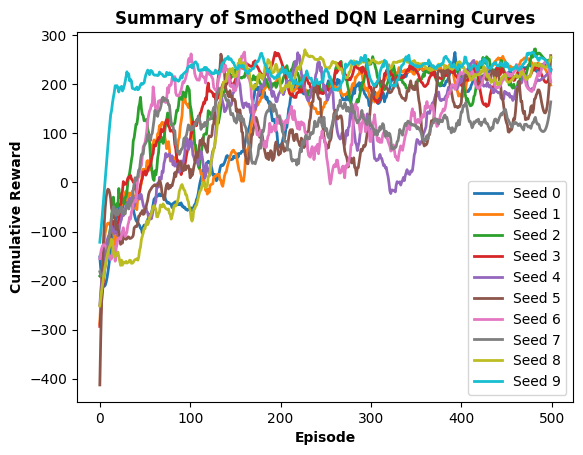

In [4]:
plot_all_learning_curves()

It is apparent from the plot above that the random seed significantly impacts the model's performance during training. Therefore, a single training run on a single seed is not a good representation of a model's performance and stability.

A good way to visualize model performance is by plotting the mean and standard deviation of multiple runs across different seeds. The number of runs to execute depends on how thorough we want to be and on the computational burden we can afford. In this example, we limit ourselves to just 10 runs. We define a plotting function below.

In [5]:
def plot_learning_curves_summary(file_name_pattern: str = 'learning_curves/learning_curve__seed={}.csv',
                                 base_url: str = "https://raw.githubusercontent.com/plibin/espidam-25/main/deep-rl/",
                                 window_length: int = 15,
                                 polyorder: int = 3) -> None:
    """
    Plots the mean and standard deviation of smoothed learning curves from multiple files using the Savitzky-Golay filter.

    Arguments
    ---------
    file_name_pattern :  The pattern for the file names, 
                         with '{}' as the placeholder for the seed number.
    base_url          :  The base URL where the CSV files are hosted.
    window_length     :  The length of the filter window.
    polyorder         :  The order of the polynomial used to fit the samples.

    """
    # List to store all cumulative rewards arrays.
    all_cumulative_rewards = []

    # Loop over the 10 files and read the learning curves.
    for seed in range(10):
        # Construct the full path or URL for the file.
        file_path_or_url = file_name_pattern.format(seed)
        
        # Load the learning curve data from the file or URL.
        cumulative_rewards = []
        try:
            if is_running_in_colab():
                # Construct the full URL for the file.
                file_url = f"{base_url}/{file_path_or_url}"
                response = requests.get(file_url)
                response.raise_for_status()  # produce an error for bad responses.
                
                # Parse the CSV content from the URL response.
                reader = csv.DictReader(response.text.splitlines())
                for row in reader:
                    cumulative_rewards.append(float(row['Cumulative Reward']))
            else:
                with open(file_path_or_url, 'r') as f:
                    reader = csv.DictReader(f)
                    for row in reader:
                        cumulative_rewards.append(float(row['Cumulative Reward']))

        # Raise an error for bad responses.   
        except Exception as e:
            print(f"Error loading data for seed {seed}: {e}")
            continue
        
        # Append the cumulative rewards to the list.
        all_cumulative_rewards.append(cumulative_rewards)

    # Check if any data was successfully loaded.
    if not all_cumulative_rewards:
        print("No valid data loaded. Check the file URLs or data format.")
        return

    # Convert the list of cumulative rewards to a numpy array for easier manipulation.
    all_cumulative_rewards = np.array(all_cumulative_rewards)

    # Calculate the mean and standard deviation across seeds.
    mean_rewards = np.mean(all_cumulative_rewards, axis=0)
    std_rewards = np.std(all_cumulative_rewards, axis=0)

    # Apply Savitzky-Golay filter to smooth the mean rewards.
    if len(mean_rewards) >= window_length:
        smoothed_mean_rewards = savgol_filter(mean_rewards, window_length=window_length, polyorder=polyorder)

    # Create a new figure for the summary plot.
    plt.figure()

    # Plot the smoothed mean cumulative rewards.
    plt.plot(smoothed_mean_rewards, label='Mean Cumulative Reward', linewidth=2, color='blue')

    # Plot the standard deviation as a shaded area.
    plt.fill_between(range(len(smoothed_mean_rewards)), 
                     smoothed_mean_rewards - std_rewards, 
                     smoothed_mean_rewards + std_rewards, 
                     color='green', alpha=0.3, label='Standard Deviation')

    # Configure plot labels and legend.
    plt.xlabel('Episode', fontweight='bold')
    plt.ylabel('Cumulative Reward', fontweight='bold')
    plt.title('Mean and Standard Deviation of DQN Learning Curves', fontweight='bold')
    plt.legend()
    plt.show()


We can now generate this summary plot.

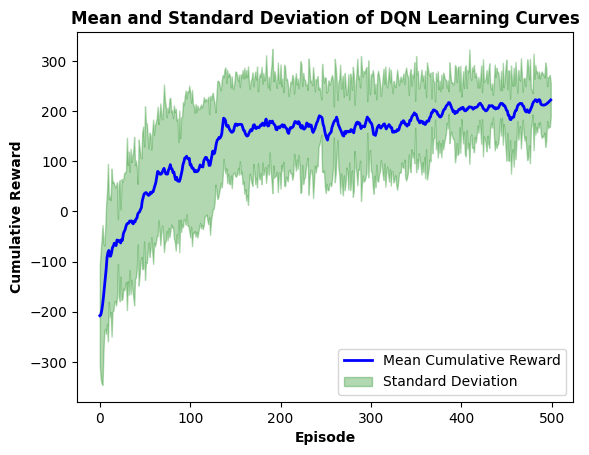

In [6]:
plot_learning_curves_summary()